<img src="https://www.th-koeln.de/img/logo.svg" style="float:right;" width="200">

# 6th exercise: <font color="#C70039">Work with Autoencoders for anomaly detection</font>
* Course: AML
* Lecturer: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Author of notebook: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Date:   01.12.2023
* Student: Ali Ünal

<img src="https://blog.keras.io/img/ae/autoencoder_schema.jpg" style="float: center;" width="700">

---------------------------------
**GENERAL NOTE 1**: 
Please make sure you are reading the entire notebook, since it contains a lot of information on your tasks (e.g. regarding the set of certain paramaters or a specific computational trick), and the written mark downs as well as comments contain a lot of information on how things work together as a whole. 

**GENERAL NOTE 2**: 
* Please, when commenting source code, just use English language only. 
* When describing an observation please use English language, too.
* This applies to all exercises throughout this course.

---------------------------------

### <font color="ce33ff">DESCRIPTION</font>:
Autoencoder is an unsupervised artificial neural network (ANN) that learns how to efficiently compress and encode data and then learns how to reconstruct the data back from the reduced encoded representation to a representation that is as close to the original input as possible.

An Autoencoder reduces data dimensions by learning how to ignore the noise in the data and thus outliers.
In the section above, you can seen an example of the input/output image from the MNIST dataset to an Autoencoder.

#### Autoencoder Components:
An Autoencoder consists of four main parts:

1. Encoder: In which the model learns how to reduce the input dimensions and compress the input data into an encoded representation.

2. Bottleneck: which is the layer that contains the compressed representation of the input data. This is the lowest possible dimensions of the input data. The bottlneck is also called latent vector. The concept of the latent space and latent vectors becomes important later on as we move forward to understand Generative Models. 

3. Decoder: In which the model learns how to reconstruct the data from the encoded representation to be as close to the original input as possible.

4. Reconstruction Loss: This is the method that measures how well the decoder is performing and how close the output is to the original input.

As always in ANNs, the training itself involves back propagation in order to minimize the network’s reconstruction loss.

Due to this features of an Autoencoder the use cases are manyfold. One of the obviously is anomaly detection. 

#### Autoencoder Architecture:

The network architecture for Autoencoders can vary between simple Feed Forward networks, Recurrent Neural Networks (LSTM) or Convolutional Neural Networks (CNN) depending on the use case. 

---------------------------------

### <font color="FFC300">TASKS</font>:
The tasks that you need to work on within this notebook are always indicated below as bullet points. 
If a task is more challenging and consists of several steps, this is indicated as well. 
Make sure you have worked down the task list and commented your doings. 
This should be done by using markdown.<br> 
<font color=red>Make sure you don't forget to specify your name and your matriculation number in the notebook.</font>

**YOUR TASKS in this exercise are as follows**:
1. import the notebook to Google Colab or use your local machine.
2. make sure you specified you name and your matriculation number in the header below my name and date. 
    * set the date too and remove mine.
3. read the entire notebook carefully 
    * add comments whereever you feel it necessary for better understanding
    * run the notebook for the first time.
    * the example below shows how to use an autoencoder for anomaly detection

4. <font color=green>Develop an Autoencoder for Domain Adaptation (Me -> Walter White ). You can of course also take own data, e.g. a photo of yours and someone else.</font>
5. Set at least the following hyperparameters for training (epochs=100000, shuffle=True).
6. Implement a CNN for working out important features for the adaptation. If you feel lost in the exercise, please visit the sample solution.
7. There is also an implementation of data augmentation that helps you building up your data set from one single "original" image. 
---------------------------------

### Auto-Encoding
If you have correlated input data, the auto-encoder method will work very well because the encoding operation relies on the correlated features to compress the data.
Let’s consider that an auto-encoder is trained on the MNIST dataset. 
As you know already, using a simple FeedForward neural network, this can be done by building a simple 6 layers network as below:

In [1]:
import numpy as np
import keras
import os
from matplotlib import pyplot as plt
import shutil
import cv2

from   keras.datasets import mnist
from   keras.models import Sequential, Model
from   keras.layers import Dense, Input
from   keras import optimizers
from   keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Sequential

from   tqdm import tqdm
import time

SIZE=256
# load the inbuild mnist data set (8bit grayscale digits)
# https://en.wikipedia.org/wiki/MNIST_database
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# normalize the training and the validation data set
train_x = x_train.reshape(60000, 784) / 255
val_x = x_test.reshape(10000, 784) / 255

# build the auto-encoding layers
autoencoder = Sequential()
autoencoder.add(Dense(512,  activation='elu', input_shape=(784,)))
autoencoder.add(Dense(128,  activation='elu'))
autoencoder.add(Dense(10,   activation='linear', name="bottleneck"))
autoencoder.add(Dense(128,  activation='elu'))
autoencoder.add(Dense(512,  activation='elu'))
autoencoder.add(Dense(784,  activation='sigmoid'))
autoencoder.compile(loss='mean_squared_error', optimizer = Adam())

'''
NOTE:
-----
The Exponential Linear Unit (ELU) is an activation function for neural networks. 
In contrast to ReLUs (which you know), ELUs have negative values which allows them to push mean unit 
activations closer to zero like batch normalization but with lower computational complexity.
'''    

# train the model and finally assign the encoding to the decoder
'''
NOTE:
-----
make sure you understand, that you are training on train_x and not on train_y but train_x again for the reconstruction
the same for the validation (val_x, val_x)
'''
trained_model = autoencoder.fit(train_x, train_x, batch_size=1024, epochs=10, verbose=1, validation_data=(val_x, val_x))
encoder = Model(autoencoder.input, autoencoder.get_layer('bottleneck').output)

encoded_data = encoder.predict(train_x)  # bottleneck representation

decoded_output = autoencoder.predict(train_x)        # reconstruction
encoding_dim = 10

# return the decoder
encoded_input = Input(shape=(encoding_dim,))
decoder = autoencoder.layers[-3](encoded_input)
decoder = autoencoder.layers[-2](decoder)
decoder = autoencoder.layers[-1](decoder)
decoder = Model(encoded_input, decoder)

Epoch 1/10
59/59 [==============================] - 2s 29ms/step - loss: 0.0769 - val_loss: 0.0514
Epoch 2/10
59/59 [==============================] - 2s 27ms/step - loss: 0.0442 - val_loss: 0.0368
Epoch 3/10
59/59 [==============================] - 2s 26ms/step - loss: 0.0333 - val_loss: 0.0296
Epoch 4/10
59/59 [==============================] - 1s 25ms/step - loss: 0.0286 - val_loss: 0.0266
Epoch 5/10
59/59 [==============================] - 1s 25ms/step - loss: 0.0260 - val_loss: 0.0244
Epoch 6/10
59/59 [==============================] - 1s 25ms/step - loss: 0.0241 - val_loss: 0.0229
Epoch 7/10
59/59 [==============================] - 2s 26ms/step - loss: 0.0228 - val_loss: 0.0217
Epoch 8/10
59/59 [==============================] - 1s 25ms/step - loss: 0.0217 - val_loss: 0.0208
Epoch 9/10
59/59 [==============================] - 1s 25ms/step - loss: 0.0208 - val_loss: 0.0201
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step


As you can see in the output, the last reconstruction loss/error for the validation set is approx. 0.0197, which is great. 
Now, if we pass any normal image from the MNIST dataset, the reconstruction loss will be very low (< 0.02) BUT if we tried to pass any other different image (outlier / anomaly), we will get a high reconstruction loss value because the network failed to reconstruct the image/input that is considered an anomaly.

Notice in the code above, you can use only the encoder part to compress some data or images and you can also only use the decoder part to decompress the data by loading the decoder layers.

#### Auto-Encoders for Anomaly Detection
Now, let’s do some anomaly detection. The code below uses two different images to predict the anomaly score (reconstruction error) using the autoencoder network we trained above. 

The first image is from the MNIST and the result is error=2.46241018. This means that the image is not an anomaly. The second image (yoda.png) obviously does not belong to the training dataset and the result is: error=2727.0718. This high error means that the image is an anomaly. Even the third image. The same concept applies to any type of dataset.

In [2]:
# If you are using a newer version of keras than '2.4.3', read this article below.
# It describes a versioning issue in the keras libs
'''https://stackoverflow.com/questions/72383347/how-to-fix-it-attributeerror-module-keras-preprocessing-image-has-no-attribu'''
from keras.preprocessing import image

# take an image from the validation data set or the training data set, respectively
input_img = val_x[50] 
input_img_flat = input_img.reshape(1,784)

target_data = autoencoder.predict(input_img_flat)

dist = np.linalg.norm(input_img_flat - target_data, axis=-1)

print(dist)

1/1 [==============================] - 0s 47ms/step
[2.67647771]


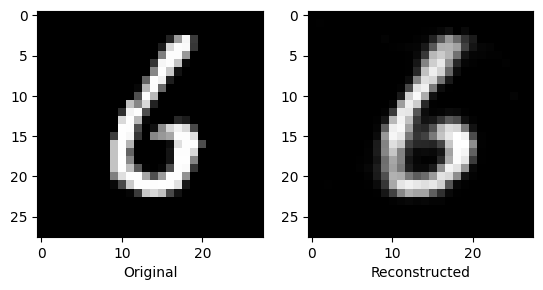

In [3]:
fig, axes = plt.subplots(1,2)
axes[0].imshow(input_img.reshape(28,28), cmap="gray")
axes[1].imshow(target_data.reshape(28, 28), cmap="gray")
axes[0].set_xlabel("Original")
axes[1].set_xlabel("Reconstructed")
plt.show()

In [4]:
# Now take Master Yoda as the test image. The error score will be very high (error=2727.0718)
img = load_img("yoda.jpg", target_size=(28, 28), color_mode = "grayscale")
input_img = img_to_array(img)

input_img_flat = input_img.reshape(1,784)
target_data = autoencoder.predict(input_img_flat)
dist = np.linalg.norm(input_img_flat - target_data, axis=-1)
print(dist)

1/1 [==============================] - 0s 11ms/step
[5133.9116]


In [5]:
''' 
Now take a Mnist image which is taken from the google image search and although it is super similar to the training data
it does not belong to the same data distribution the auto-encoder was trained on. 
It produces an error almost as high as yoda.png (approx error=2551.99)
This makes autoencoders being a very robust technique for anomaly detection.
'''
img = load_img("mnist.png", target_size=(28, 28), color_mode = "grayscale")
input_img = img_to_array(img)

input_img_flat = input_img.reshape(1,784)
target_data = autoencoder.predict(input_img_flat)
dist = np.linalg.norm(input_img_flat - target_data, axis=-1)

print(dist)

1/1 [==============================] - 0s 14ms/step
[3819.961]


In [6]:
#in the results above we see that even though the second image is similar the error score is still high. But the yoda image scores even worse than the mnist.png
# as for the reconstructed 6, the results looks pretty promising even though some pixels are missing
# a higher error indicates an outlier since the autodecoder is trained on the non-outlier data

### Generating-Images

In [ ]:
# we are using the the generating-images code that you provided
# after that we load and normalize the images

In [7]:
def generate__augment_images(input_folder, output_folder, n=50):
    # Initialize ImageDataGenerator
    datagen = ImageDataGenerator(
        rotation_range=90,
        horizontal_flip=True,
        vertical_flip=True,
        width_shift_range=45.0,
        height_shift_range=45.0
    )

    # Get list of image names in the input folder
    image_names = os.listdir(input_folder)

    print('image_names:', image_names)
    
    # Remove existing files in the output folder
    for file_name in os.listdir(output_folder):
        file_path = os.path.join(output_folder, file_name)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
        except Exception as e:
            print(e)

    # Iterate through each image in the input folder
    for filename in image_names:
        print(filename)
        # Load the image
        img = load_img(os.path.join(input_folder, filename))
        x = img_to_array(img)
        x = x.reshape((1, ) + x.shape)
        i = 0

        # Generate n new augmented images and store them in the output folder
        for batch in datagen.flow(x, batch_size=1, save_to_dir=output_folder, save_prefix='aug', save_format='jpg'):
            i += 1
            if i > n:
                break

# Example usage:
input_folder = "gernot"
output_folder = 'augmentedGernot'
generate__augment_images(input_folder, output_folder)
input_folder = "walter"
output_folder = 'augmentedWalter'
generate__augment_images(input_folder, output_folder)

image_names: ['th_heisenberg.png']
th_heisenberg.png
image_names: ['heisenberg.jpg']
heisenberg.jpg


### Load-and-normalize Images

In [9]:
def normalize_images(input_path, output_path, test_img_path, SIZE):
    
    # import input img
    input_img_data = []
    input_files = os.listdir(input_path)
    for i in tqdm(input_files):
        img = cv2.imread(os.path.join(input_path, i), 1)  # Change 0 to 1 for color images
        img = cv2.resize(img, (SIZE, SIZE))
        input_img_data.append(img_to_array(img))
        
    # import output_img
    output_img_data = []
    output_files = os.listdir(output_path)
    for i in tqdm(output_files):
        img = cv2.imread(os.path.join(output_path, i), 1)  # Change 0 to 1 for color images
        img = cv2.resize(img, (SIZE, SIZE))
        output_img_data.append(img_to_array(img))

    input_img_array = np.reshape(input_img_data, (len(input_img_data), SIZE, SIZE, 3))
    input_img_array = input_img_array.astype('float32') / 255.0  # normalize

    output_img_array = np.reshape(output_img_data, (len(output_img_data), SIZE, SIZE, 3))
    output_img_array = output_img_array.astype('float32') / 255.0  # normalize

    # Original image for prediction of output_img
    # this one does not belong to the training set
    test_img_data = []

    test_img = cv2.imread(test_img_path, 1)  # Change 0 to 1 for color images
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)  # Changing BGR to RGB to show images in true colors
    test_img = cv2.resize(test_img, (SIZE, SIZE))
    test_img_data.append(img_to_array(test_img))

    test_img_array = np.reshape(test_img_data, (len(test_img_data), SIZE, SIZE, 3))
    test_img_array = test_img_array.astype('float32') / 255.0  # normalize

    # set the start time
    # later needed for calculating the computation time
    start = time.time()

    return input_img_array, output_img_array, test_img_array, start

# Example usage:
SIZE = 224
input_path = 'augmentedGernot'
output_path = 'augmentedWalter'
test_img_path = 'heisenberg.jpg'

input_img_array, output_img_array, test_img_array, start = normalize_images(input_path, output_path, test_img_path, SIZE)


100%|█████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 144.85it/s]


In [10]:
def create_autoencoder_model(SIZE):
    # Create a Sequential model
    model = Sequential()

    # Encoder
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3)))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))

    # The golden middle

    # Decoder
    model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(3, (3, 3), activation='relu', padding='same'))

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

    # Print model summary
    model.summary()

    return model

# Example usage:
model = create_autoencoder_model(SIZE)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 8)       2312      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 8)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 8)         584       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 8)       

continue the process of training the convolutional autoencoder model you created earlier

In [11]:
def train_model(input_img_array, output_img_array, epochs, start):
    
    # Define TensorBoard callback
    # callbacks = [tf.keras.callbacks.TensorBoard(log_dir='einstein_logs')]

    # Fit the model of input_img to output_img
    model.fit(input_img_array, output_img_array, epochs=epochs, shuffle=True)# callbacks=callbacks)

    # Print out the computation time
    finish = time.time()
    print('total computation time = ', finish - start)

    # Save the model
    # model.save("domain_adapt_autoenc_epochs." + str(epochs) + ".model")

# Example usage
train_model(input_img_array, output_img_array, 50, start)

Epoch 1/50
2/2 [==============================] - 3s 823ms/step - loss: 0.0747 - accuracy: 0.8261
Epoch 2/50
2/2 [==============================] - 2s 801ms/step - loss: 0.0568 - accuracy: 0.9761
Epoch 3/50
2/2 [==============================] - 2s 853ms/step - loss: 0.0470 - accuracy: 0.9851
Epoch 4/50
2/2 [==============================] - 2s 839ms/step - loss: 0.0437 - accuracy: 0.9810
Epoch 5/50
2/2 [==============================] - 2s 890ms/step - loss: 0.0362 - accuracy: 0.9723
Epoch 6/50
2/2 [==============================] - 2s 845ms/step - loss: 0.0347 - accuracy: 0.9414
Epoch 7/50
2/2 [==============================] - 2s 860ms/step - loss: 0.0329 - accuracy: 0.7509
Epoch 8/50
2/2 [==============================] - 2s 850ms/step - loss: 0.0308 - accuracy: 0.0850
Epoch 9/50
2/2 [==============================] - 2s 837ms/step - loss: 0.0310 - accuracy: 0.0357
Epoch 10/50
2/2 [==============================] - 2s 809ms/step - loss: 0.0295 - accuracy: 0.0453
Epoch 11/50
2/2 [==

output of test image
1/1 [==============================] - 0s 69ms/step


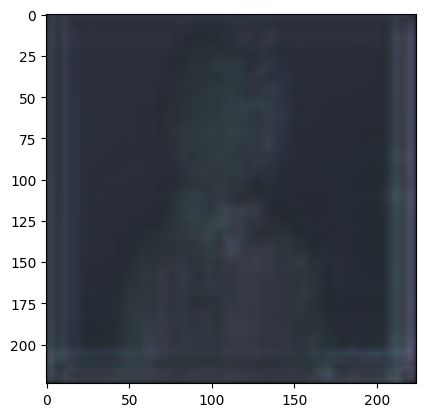

In [12]:
# predict the original image as test image, 
# since it did not belong to the training data.
# if the domain was really adapted, then the result would look like output_img
print("output of test image")
pred = model.predict(test_img_array)
plt.imshow(pred[0].reshape(SIZE,SIZE,3))
plt.show()

In [ ]:
# the test image doesnt look so well, the autoencode should be trained more
# but we dont have the computing power to match, atleast we think so
# in theorie we would for starters just increase the number of epochs over which the modell is trained
# if that doesnt improve the results it would be necessary to change the hyperparameters of the training